In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('Bangalore.csv')
df.head(10)

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,30000000,3340,JP Nagar Phase 1,4,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,8358000,1675,Doddanekundi,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6845000,1670,Kengeri,3,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
5,6797000,1220,Horamavu,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
6,20000000,2502,Thanisandra,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
7,7105000,1438,Ramamurthy Nagar,3,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
8,8405000,1405,Whitefield Hope Farm Junction,3,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
9,3506000,660,Electronic City Phase 1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
len(df)

6207

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6207 entries, 0 to 6206
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Price                6207 non-null   int64 
 1   Area                 6207 non-null   int64 
 2   Location             6207 non-null   object
 3   No. of Bedrooms      6207 non-null   int64 
 4   Resale               6207 non-null   int64 
 5   MaintenanceStaff     6207 non-null   int64 
 6   Gymnasium            6207 non-null   int64 
 7   SwimmingPool         6207 non-null   int64 
 8   LandscapedGardens    6207 non-null   int64 
 9   JoggingTrack         6207 non-null   int64 
 10  RainWaterHarvesting  6207 non-null   int64 
 11  IndoorGames          6207 non-null   int64 
 12  ShoppingMall         6207 non-null   int64 
 13  Intercom             6207 non-null   int64 
 14  SportsFacility       6207 non-null   int64 
 15  ATM                  6207 non-null   int64 
 16  ClubHo

This dataset is already available on Kaggle in cleaned up form and we can see there are no missing values in any of the columns. (6207/6207 for all features). We also see that there are close to 40 potential features that can determine the price of the apartment. Except for 'Area', 'Location' and 'No. of Bedrooms' all other features are Boolean type, i.e. either present or not present. We do not have any ordinal features (such as good/average or old/new etc in this case).

A key metric in the housing industry, at least in India, is **"Price Per Square Feet (Price/Area)"**, expressed as **Rupees Per Square Feet (Rupee being our currency)**. Almost everyone uses this metric to compare the prices as it eliminates the impact of house size. Let us add a column that captures Price Per Square Feet. We will call this **"PricePSF"** in short

In [5]:
df['PricePSF'] = df['Price'] / df['Area']

Let us check the distribution of the non-boolean and non-string elements of our data



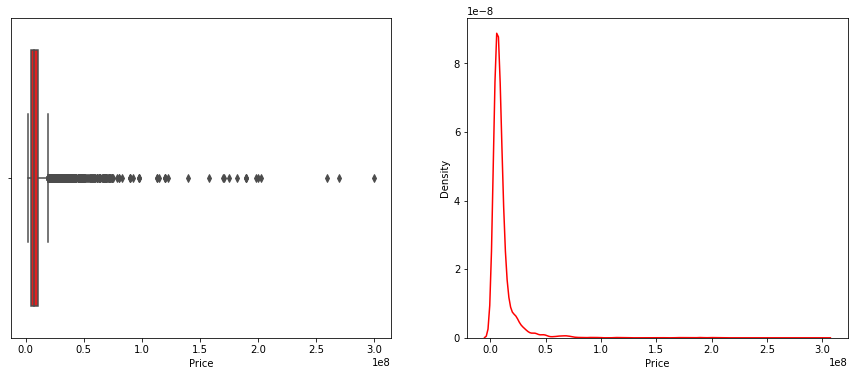

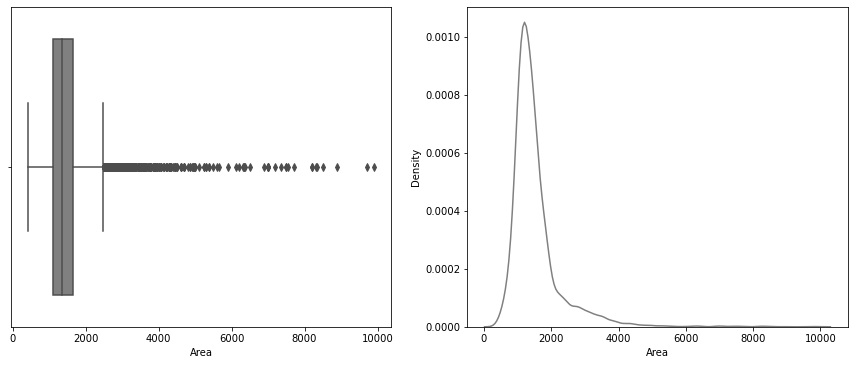

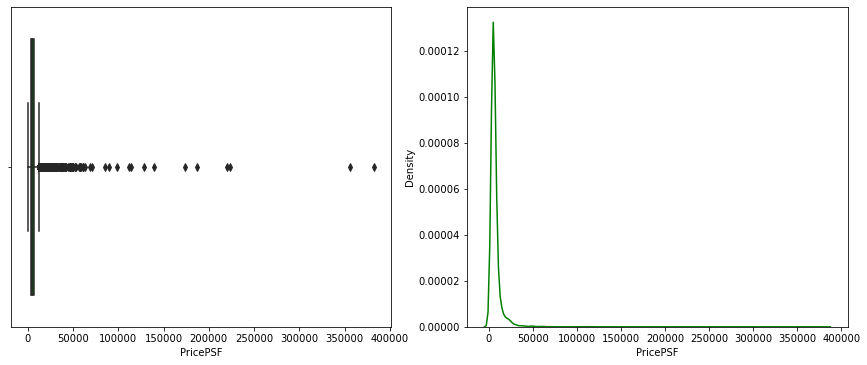

In [6]:
def dist_plot (feature, color, position=321):
    plt.figure(figsize=(15,20))
    plt.subplot(position)
    sns.boxplot(x=feature, data=df, color=color)
    plt.subplot(position+1)
    sns.kdeplot(df[feature], color=color)
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'green')

The data heavily right-skewed for Price and Area both. One would expect that PricePSF would be normally distributed as it is a ratio, however it is not so. This indicates either or both of the following:

<li>There is much more skewness in Price compared to Area</li>
<li>The houses with high Prices are not necessarily the ones with the large Area, hence PricePSF is not able to normalize such cases</li>
We now proceed to remove outliers so that they don't have a lopsided impact on our model. As the data is heavily right skewed, we remove a higher percentile (10%) from the top versus bottom(5%)

In [7]:
# define outliers
price_psf_outliers = np.percentile(df.PricePSF, [5,90])
price_outliers = np.percentile(df.Price, [5,90])
area_outliers = np.percentile(df.Area, [5,90])
# create filters based on outliers
price_psf_filter = (df.PricePSF > price_psf_outliers[0]) & (df.PricePSF < price_psf_outliers[1])
price_filter = (df.Price > price_outliers[0]) & (df.Price < price_outliers[1])
area_filter = (df.Area > area_outliers[0]) & (df.Area < area_outliers[1])
# apply filters
df = df[(price_psf_filter) & (price_filter) & (area_filter)]

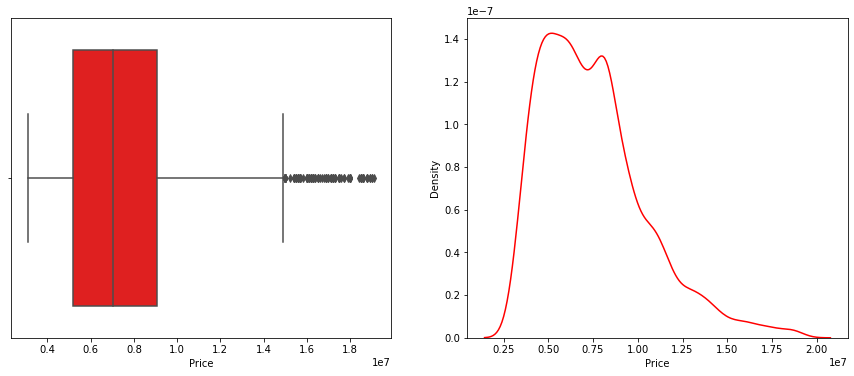

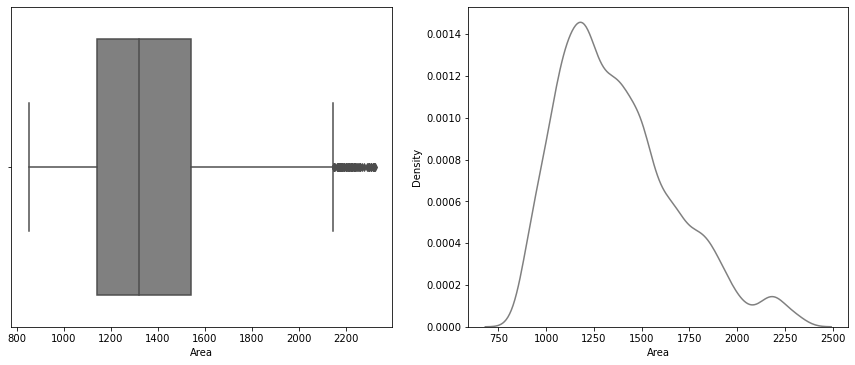

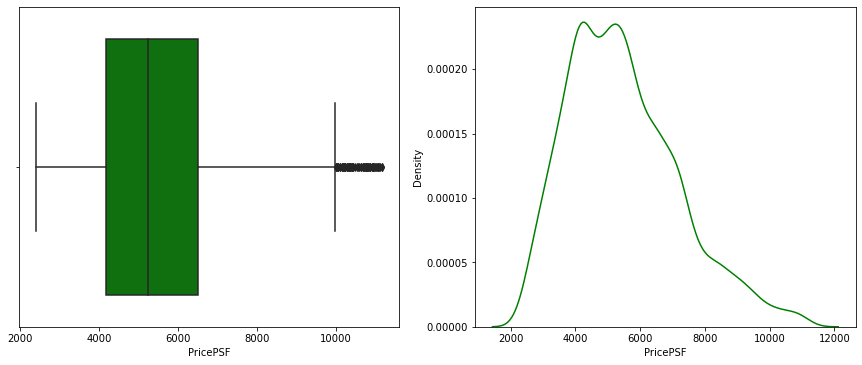

In [8]:
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'green')

In [9]:
df.columns

Index(['Price', 'Area', 'Location', 'No. of Bedrooms', 'Resale',
       'MaintenanceStaff', 'Gymnasium', 'SwimmingPool', 'LandscapedGardens',
       'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames', 'ShoppingMall',
       'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
       '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter',
       'Cafeteria', 'MultipurposeRoom', 'Hospital', 'WashingMachine',
       'Gasconnection', 'AC', 'Wifi', 'Children'splayarea', 'LiftAvailable',
       'BED', 'VaastuCompliant', 'Microwave', 'GolfCourse', 'TV',
       'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator', 'PricePSF'],
      dtype='object')

In [10]:
df.rename(columns={'No. of Bedrooms' : 'Bedrooms' , "Children'splayarea":'PlayArea'},inplace=True)
# df

### Trying to reduce number of features

As we can see from the columns list, there are a lot of features, most of them binary. Most of the binary features will fit under the broad category of Amenities. In the following section I have tried to calculate feature scores for each house bases on the Amenities being absent or present.

Note: Important - I have assigned weights to binary features based on my discretion. You are free to use the weights you want. I have also used a scale of 0-4 (0 being least important and 4 being most important). Again the choice of this scale is entirely up to you.

In [11]:
feature_dict = {'MaintenanceStaff':2, 'Gymnasium':4, 'SwimmingPool':4,'LandscapedGardens':3, 
                'JoggingTrack':3, 'RainWaterHarvesting':2,'IndoorGames':3, 'ShoppingMall':2, 
                'Intercom':2, 'SportsFacility':3, 'ATM':2, 'ClubHouse':2, 'School':2, '24X7Security':1, 
                'PowerBackup':4, 'CarParking':3, 'StaffQuarter':0, 'Cafeteria':0, 'MultipurposeRoom':2,
                'Hospital':3, 'WashingMachine':0, 'Gasconnection':2, 'AC':0, 'Wifi':0, 'PlayArea':3,
                'LiftAvailable':0, 'BED':0, 'VaastuCompliant':0, 'Microwave':0,
                'GolfCourse':0, 'TV':0, 'DiningTable':0, 'Sofa':0, 'Wardrobe':0, 'Refrigerator':0
               }

In [12]:
features = pd.DataFrame(feature_dict.items(), columns=['Features', 'Weight'])
features.shape

(35, 2)

To arrive at Feature Score for each house, we need to calculate dot product between the features matrix and the features binaries. Before this, we need to subset a features matrix from the dataset

In [13]:
features_matrix = df[['MaintenanceStaff', 'Gymnasium', 'SwimmingPool',
       'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting',
       'IndoorGames', 'ShoppingMall', 'Intercom', 'SportsFacility', 'ATM',
       'ClubHouse', 'School', '24X7Security', 'PowerBackup', 'CarParking',
       'StaffQuarter', 'Cafeteria', 'MultipurposeRoom', 'Hospital',
       'WashingMachine', 'Gasconnection', 'AC', 'Wifi', 'PlayArea',
       'LiftAvailable', 'BED', 'VaastuCompliant', 'Microwave',
       'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe',
       'Refrigerator']]
features_matrix.tail(10)

,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
6194,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6195,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6197,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6199,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6200,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6201,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6203,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6204,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6205,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6206,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


Some examination (not shown here) revelas that the features matrix contains (0, 1, 9) as values. I would assume that 9 represents NaN. Let us replace all 9s by 0s

In [14]:
features_matrix.replace(9,0,inplace=True)

D:\softwares\anaconda\app\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [15]:
# apply dot product to compute feature score for every row
feature_scores_df = np.dot(features_matrix, features['Weight'])
feature_scores_df

array([37, 22,  6, ...,  0,  0,  0], dtype=int64)

In [16]:
# join feature scores column with dataframe
df['FeatureScore'] = feature_scores_df
df.head(10)

,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,7548.325359,37
2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,4127.226463,22
3,8358000,1675,Doddanekundi,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4989.850746,6
4,6845000,1670,Kengeri,3,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,4098.802395,41
5,6797000,1220,Horamavu,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,5571.311475,39
7,7105000,1438,Ramamurthy Nagar,3,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,4940.890125,24
8,8405000,1405,Whitefield Hope Farm Junction,3,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,5982.206406,25
10,7700000,1362,Yelahanka,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,5653.450808,34
11,9369000,1735,Anjanapura,3,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,5400.000000,39
12,8716000,1575,Jalahalli,3,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,5533.968254,29


We have now reduced the number of features on which to run our regression model. These are:
<ol>
    <li>Area (numeric)</li>
    <li>Location (string). In next section I will propose a way to tackle this.</li>
    <li>Bedrooms (numeric)</li>
    <li>Feature Score (numeric)</li>
    <li>Resale (boolean)</li>
</ol>

#### Before we proceed let us check if our numerical features have any colinearity

<AxesSubplot:>

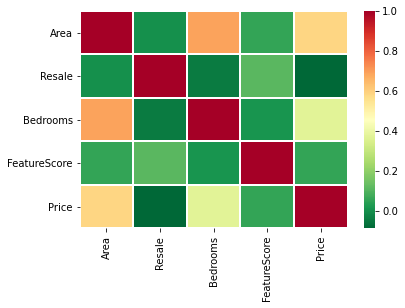

In [17]:
corr_df = df[['Area', 'Resale', 'Bedrooms', 'FeatureScore', 'Price']]
sns.heatmap(corr_df.corr(method='pearson'), cmap='RdYlGn_r', linewidths=1)

### Observations
<br>
<ol>
    <li>We can see that <strong>Area and Bedrooms are somewhat correlated</strong>. This is not surprising as houses with larger area will tend to have more bedrooms and vice versa.</li>
<li>Area has a stronger correlation with Price compared to Bedrooms. If forced to make a choice, we should drop bedrooms to avoid colinearity</li>
<li>Interestingly FeatureScore does not seem to be correlated to Price. However, remember that the feature weights were my arbitrary choice and may be wrong. An industry expert can help here. For this analysis we will retain FeatureScore in our model</li>
    </ol>

### Let us now explore how we can model Location as a numeric feature

In [18]:
# Create a pivot table of Locations with PricePSF as the value
location_pivot = pd.pivot_table(data=df, index='Location', aggfunc='mean', values='PricePSF')
location_pivot

,PricePSF
Location,
5th Phase,5327.547721
5th Stage BEML Layout,5527.356322
5th Stage Raja Rajeshwari Nagar,4727.549774
6th phase jp nagar,5226.666667
8th Phase JP Nagar,6221.070320
...,...
Yelahanka New Town,2766.956522
Yerthiganahalli,7691.522763
Yeshwantpur,5424.059214


Location is one of the most important determinants of house price. As a bit of feature engineering, I am going to calculate the 'Location Premium' for every Location. This is nothing but the PricePSF for every location divided by the minimum PricePSF. This sets the cheapest location as the base location (with a score of 1) and every other location has a premium as a multiple of that base location

In [19]:
location_pivot['LocationPremium'] = location_pivot['PricePSF'] / location_pivot['PricePSF'].min()
location_pivot.sort_values('LocationPremium', ascending=False)

,PricePSF,LocationPremium
Location,,
Volagerekallahalli,10771.889401,4.362553
Bannerughatta,9684.684685,3.922242
Frazer Town,9545.454545,3.865854
Hoskote,9403.107114,3.808204
BTM Layout,9017.580859,3.652068
...,...,...
Sompura Gate,2689.843217,1.089371
Nagawara,2583.586626,1.046338
Ashoka Road,2555.555556,1.034985


We now merge the location pivot with the df dataframe on 'Location' column

In [20]:
df = pd.merge(df, location_pivot['LocationPremium'], on='Location')

In [21]:
df.head(10)

,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore,LocationPremium
0,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7548.325359,37,2.552363
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7548.325359,37,2.552363
2,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7548.325359,37,2.552363
3,9412000,1247,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7547.714515,37,2.552363
4,10500000,1486,Dasarahalli on Tumkur Road,3,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7065.948856,37,2.552363
5,10200000,1433,Dasarahalli on Tumkur Road,3,0,0,1,1,1,1,...,0,0,0,0,0,0,0,7117.934403,37,2.552363
6,9960000,1086,Dasarahalli on Tumkur Road,1,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9171.270718,0,2.552363
7,9960000,1086,Dasarahalli on Tumkur Road,1,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9171.270718,0,2.552363
8,5900000,1086,Dasarahalli on Tumkur Road,1,0,9,9,9,9,9,...,9,9,9,9,9,9,9,5432.780847,0,2.552363
9,5900000,1086,Dasarahalli on Tumkur Road,1,0,9,9,9,9,9,...,9,9,9,9,9,9,9,5432.780847,0,2.552363


In [24]:
df['LogPremium'] = np.log(df['LocationPremium'])
df

,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore,LocationPremium,LogPremium
0,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,7548.325359,37,2.552363,0.937020
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,7548.325359,37,2.552363,0.937020
2,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,7548.325359,37,2.552363,0.937020
3,9412000,1247,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,0,0,0,0,0,0,7547.714515,37,2.552363,0.937020
4,10500000,1486,Dasarahalli on Tumkur Road,3,0,0,1,1,1,1,...,0,0,0,0,0,0,7065.948856,37,2.552363,0.937020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,4100000,1212,Vijaya Bank Layout,2,0,9,9,9,9,9,...,9,9,9,9,9,9,3382.838284,0,1.370030,0.314833
4449,7950000,1100,Banashankari Stage III,2,0,9,9,9,9,9,...,9,9,9,9,9,9,7227.272727,0,2.927004,1.073979
4450,3869000,1310,Bellari Road,2,0,9,9,9,9,9,...,9,9,9,9,9,9,2953.435115,0,1.196124,0.179087
4451,4057000,1010,Kachanayakanahalli,2,0,9,9,9,9,9,...,9,9,9,9,9,9,4016.831683,0,1.626794,0.486611


## Start training model

In [25]:
x = df[['Area', 'FeatureScore', 'Resale', 'LogPremium', 'Bedrooms']]
y = df['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)

In [26]:
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              8506.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):                        0.00
Time:                        19:20:43   Log-Likelihood:                         -57163.
No. Observations:                3562   AIC:                                  1.143e+05
Df Residuals:                    3557   BIC:                                  1.144e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Area          4775.6753    176.260     27.095      0.000    4430.095    5121.255
FeatureScore  4009.2513   2391.683      1.676      0.094    -679.957    8698.460
Resale       -9.644e+05   1.39e+05     -6.943      0.000   -1.24e+06   -6.92e+05
LogPremium     4.31e+06   1.91e+05     22.621      0.000    3.94e+06    4.68e+06
Bedrooms      -8.98e+05   9.05e+04     -9.925      0.000   -1.08e+06   -7.21e+05
==============================================================================
Omnibus:                      451.081   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              735.811
Skew:                           0.870   Prob(JB):                    1.66e-160
Kurtosis:                       4.388   Cond. No.                     7.12e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Observations
<br>
<ol>
<li>R squared value of 92.3% is good. However, we are yet to see how the model performs on test data</li>
<li>Feature Score has a p-value of greater than 0.05, indicating that it is not an important determinant of price. Either that or I have not engineered it well.</li>
<li>FeatureScore also has a very high range (even entering negative territory). Clearly there is much more to be engineered here as presence of even a single feature should not reduce the price of a house.</li>
<li>Bedrooms has a negative coefficient, indicating more bedrooms lower the price. This seems like an anomaly and is a likely result of colinearity between bedrooms and Area. If modeled in the absense of Area, Bedrooms may result in a positive correlation.</li>
<li>'Resale = True' negatively impacts the price, which is understandable. However the extent (almost a million Rupees) may be a subject for further analysis for industry experts</li>
</ol>

In [27]:
x_train.shape[1]

5

Text(0, 0.5, 'Predicted Test Prices')

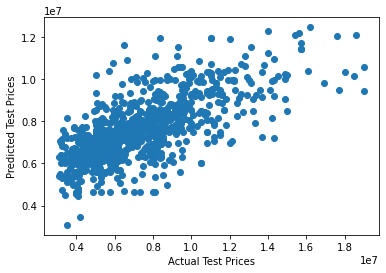

In [30]:
predictions = model.predict(x_test)
plt.scatter(x=y_test, y=predictions)
plt.xlabel('Actual Test Prices')
plt.ylabel('Predicted Test Prices')

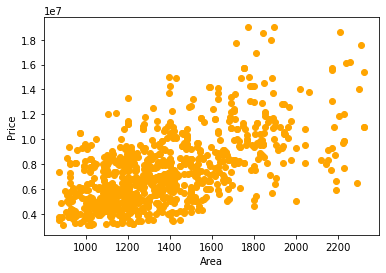

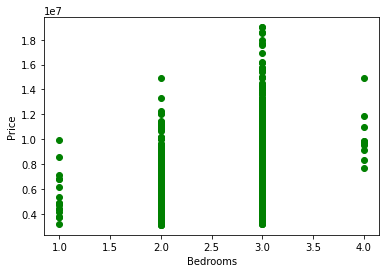

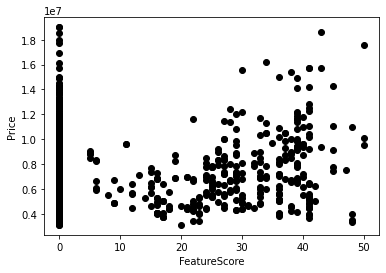

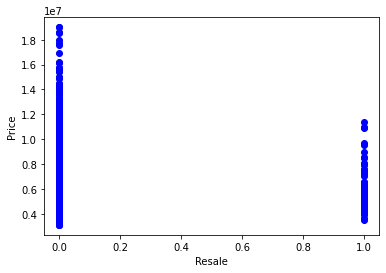

In [31]:
plt.scatter(x_test['Area'],y_test,color='orange')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

plt.scatter(x_test['Bedrooms'],y_test,color='green')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

plt.scatter(x_test['FeatureScore'],y_test,color='black')
plt.xlabel('FeatureScore')
plt.ylabel('Price')
plt.show()

plt.scatter(x_test['Resale'],y_test,color='blue')
plt.xlabel('Resale')
plt.ylabel('Price')
plt.show()

### Observations
<ul>
    <li> As area of house is increasing price is also increasing which is obivos</li>
    <li> Houses with 3 bedrooms is most costly compared to 1,2 and 4 bedrooms</li>
    <li> Higher the feature score higher should be the price but in our example feature score was not properly caliberated</li>
    <li> House which is not a resale has higer price than compared to that of a resale house</li>    

In [32]:
mean_absolute_error(y_test,predictions)

1658513.7874001332

In [33]:
predictions.mean()

7638996.812303054